# Constructing a Mobility Network

Welcome! In this code sample, we'll illustrate how to construct a mobility network from data on commuting flows collected through the Census Transportation Planning Products program. Our core data set gives the estimated number of people commuting from one Census tract to another. We'll need a few tools; as illustrated below, use `pip install <packagename>` to ensure you have everything you need. 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import math
try:
    import powerlaw 
    import mpmath
except:
    !pip install powerlaw
    !pip install mpmath
    import mpmath
    import powerlaw 

%matplotlib inline
%pylab inline
sb.set()

Populating the interactive namespace from numpy and matplotlib


# Reading the Data

The data consists of the tract number for the origin, the tract number for the destination, and the estimated number of people commuting between them. This subset of the CTPP data includes all commuting flows that either begin or end in the state of Rhode Island. 

In [2]:
data = pd.read_csv('flows.csv',sep=',',header=0, dtype = {'o':str, 'd': str})
data.head()

,o,d,flow
0,44007003602,44007003602,1050
1,44009050600,44009050600,1020
2,44009051400,44009051400,940
3,44005041200,44005041200,855
4,44005041300,44005041300,775


The total number of commuters represented in this data set is: 

In [3]:
data.flow.sum()

549218

The number of distinct flows included in those trips is: 

In [4]:
len(data)

19216

# Constructing a Network

We're ready to construct a graph from our flows data! We'll start with the most detailed version, a directed graph in which an edge from node *i* to node *j* represents commuters from tract *i* to tract *j*: 

In [5]:
gd = nx.DiGraph()    #directed graph
for i in range(len(data)):
       gd.add_edge(data.o[i],data.d[i],weight=data.flow[i])

It's useful to inspect the structure of the edges to make sure we get what we are expecting: 

In [6]:
gd.edges(data=True)[1:5]

[('53027000700', '44007000800', {'weight': 4}),
 ('25005644200', '44007000800', {'weight': 25}),
 ('25005644200', '44007013101', {'weight': 10}),
 ('25005644200', '44007012601', {'weight': 10})]

In [7]:
print len(gd.nodes())
print len(gd.edges())

1760
19216


Looks good! Now let's try a basic visualization: 

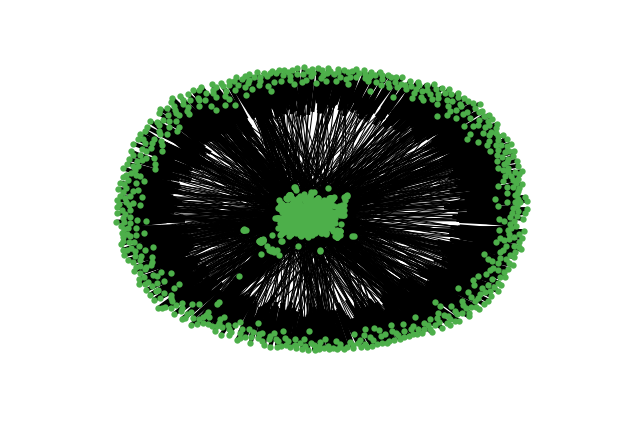

In [8]:
pos = nx.spring_layout(gd) ### This can be changed to keep coordinates
nx.draw(gd,pos=pos,node_color="#4daf4a",node_size=40,font_size=11,linewidths=0,font_color='w')

It's nice to know that our network is in good shape. This isn't the most informative visualization, but we'll see a more readable one once we simplify our network a bit. 

# Simplifying the Network

In some applications, we care only about the total flow between two locations, rather than how many are going in which direction. Starting with our detailed graph, it's easy to construct the simplified version: 

In [9]:
g = nx.Graph();
i=0;
for edge in gd.edges(data=True):
    i=i+1;
    if g.has_edge(edge[0], edge[1]):
        oldWeight = g.get_edge_data(edge[0], edge[1])['weight']
        newWeight = (edge[2]['weight'] + oldWeight) 
        g.add_edge(edge[0], edge[1],weight=newWeight)
    else:
        g.add_edge(edge[0], edge[1],weight=edge[2]['weight'])

Number of nodes and edges

In [10]:
print len(g.nodes())
print len(g.edges())

1760
16900


# Visualizing the Simplified Network

We can visualize our network using the same techniques as before: 

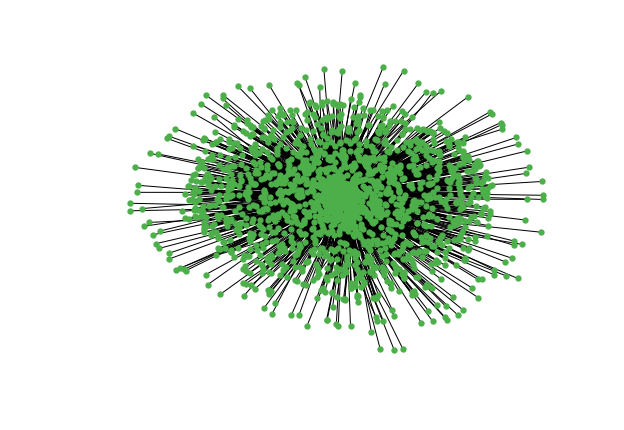

In [11]:
pos = nx.spring_layout(g) ### This can be changed to keep coordinates
nx.draw(g,pos=pos,node_color="#4daf4a",node_size=40,font_size=11,linewidths=0,font_color='w')

Suppose that we want to visualize this network in space using the locations of the tracts. To do this, we need to match tract the coordinates of the centroids to their labels. The code below reads in a shapefile for PVD and computes the centroids: 

In [12]:
import fiona
from shapely.geometry import MultiPolygon, Point, shape

tracts_raw = fiona.open('PVD/PVD.shp')
d = {tract['properties']['GEOID'] : shape(tract['geometry']).centroid.coords[:][0] for tract in tracts_raw}

Now that we have the list, we can redraw the network. To keep the visualization clean, we'll show only those commuting flows that both begin and end in Rhode Island.   

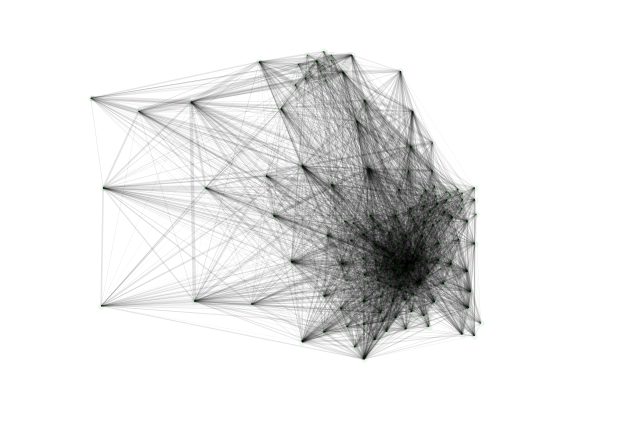

In [13]:
g_sub = g.copy()

for n in g_sub.copy().node:
    if n not in d.keys():
        g_sub.remove_node(n)

pos = {node : d[node] for node in g_sub.node}
edgewidth = [ .02 * w['weight'] for (u,v,w) in g_sub.edges(data=True)]

nx.draw(g_sub,
        pos=pos,
        node_color="#4daf4a",
        node_size=40,
        font_size=11,
        linewidths=0,
        font_color='w',
        width = edgewidth,
        alpha = .1)

# Basic Network Analysis

Now we'll illustrate some elementary techniques in network analysis for characterizing the mobility network we've constructed. First, let's plot the degree distribution of the network. First we compute the degrees and prepare for plotting.... 

In [14]:
# create list of degrees and weighted degrees
out_w = []
out_d = []
for node in g.nodes(data=True):
    out_sum= 0
    out = 0
    for e in g.edges(node[0],data=True):
        out_sum+=e[2]['weight']
        out+=1
    out_w.append(int(out_sum))
    out_d.append(int(out))

...and then we plot! 

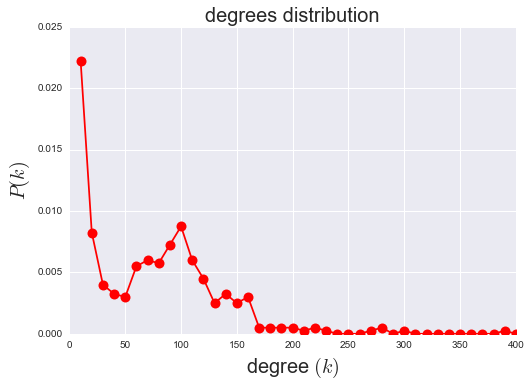

In [15]:
n, bins = np.histogram(out_d, bins = range(10, max(out_d)+20, 10), normed="True") 
# plot
plt.figure(1)
plt.plot(bins[:-1],n,'o-',markersize=10,color='red') 
plt.title("degrees distribution",fontsize=20)
plt.xlabel('degree $(k)$',fontsize=20)
plt.ylabel('$P(k)$',fontsize=20) 
plt.minorticks_off()
plt.savefig("dist_degree.png",dpi=200,bbox_inches='tight')

Node the extreme heterogeneity in the nodes: while many nodes only connect to one other location, others connect to hundreds. 

# Distribution for weighted degrees

We might also be interested in *weighting* the degrees by the amount of flow between them, leading to the following plots: 

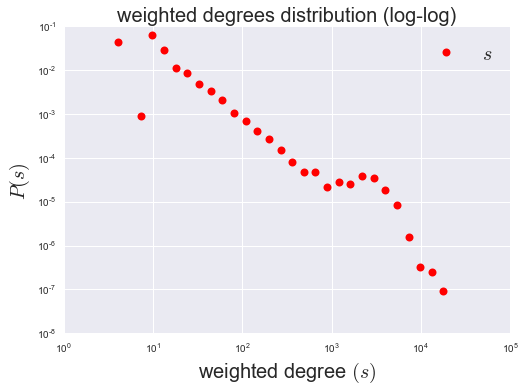

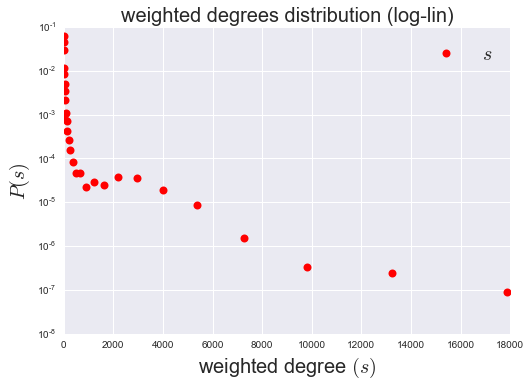

In [16]:
n_bins = 30
n, bins = np.histogram(out_w, bins = range(min(out_w), max(out_w)+1, 2), normed="True") 

out_logBins = np.logspace(np.log10(min(out_w)), np.log10(max(out_w)),num=n_bins)
out_logBinDensity, out_binedges = np.histogram(out_w, bins=out_logBins, density=True)

# plot
plt.figure(1)
#plt.figure(figsize=(18,8))
plt.loglog(out_logBins[:-1],out_logBinDensity,'o', markersize=8,label=r'$s$',color='r')
plt.legend(fontsize=20)

plt.title("weighted degrees distribution (log-log)",fontsize=20)
plt.xlabel('weighted degree $(s)$',fontsize=20)
plt.ylabel('$P(s)$',fontsize=20) 
plt.minorticks_off()
plt.savefig("dist_weighted_degree.png",dpi=200,bbox_inches='tight')

plt.figure(2)
#plt.figure(figsize=(18,8))
plt.yscale('log')
plt.plot(out_logBins[:-1],out_logBinDensity,'o', markersize=8,label=r'$s$',color='r')
plt.legend(fontsize=20)

plt.title("weighted degrees distribution (log-lin)",fontsize=20)
plt.xlabel('weighted degree $(s)$',fontsize=20)
plt.ylabel('$P(s)$',fontsize=20) 
plt.minorticks_off()
plt.savefig("dist_weighted_degree_log_lin.png",dpi=200,bbox_inches='tight')


The flows between tracks is very heterogeneous

# Trips as a function of out going trips of each node

As one final illustrative analysis, we consider the following question: are highly connected nodes closely connected to each other? For example, we might expect that downtown Boston and downtown Providence, two areas that are highly connected, might have a large amount of flow between them. We can test this hypothesis by plotting, for each edge, the product of the node degrees vs the flow between them. The below code plots these two quantities against each other: 

In [17]:
degrees = nx.degree(g);

kk = []
wij = []
for edge in g.edges(data=True):
    kk.append(degrees[edge[0]]*degrees[edge[1]]) # multiplying degrees
    wij.append(edge[2]['weight'])

In [18]:
n_bins = 30
kk_logBins = np.logspace(np.log10(min(kk)), np.log10(max(kk)),num=n_bins)
counts, bins = np.histogram(kk, bins=kk_logBins);
sums, bins = np.histogram(kk, bins=kk_logBins,weights=wij);
avg_w = sums/counts;

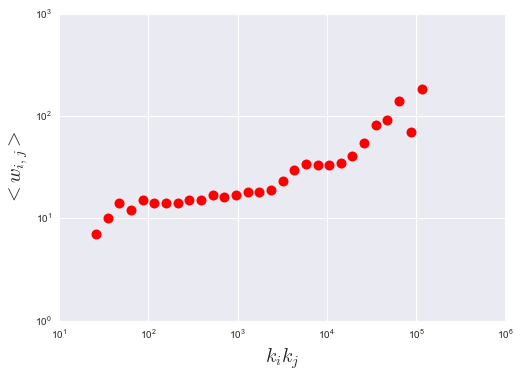

In [19]:
plt.loglog(bins[:-1],avg_w,linewidth=0,color='r',marker='o',markersize=10)
plt.xlabel('$k_ik_j$',fontsize=20)
plt.ylabel('$<w_{i,j}>$',fontsize=20)
plt.minorticks_off()
plt.savefig("commutes.png",dpi=200,bbox_inches='tight')

We see that highly connected nodes do tend to be closely connected to each other. Additionally, there is some interesting qualitative behavior in the middle range of the graph, which may reflect structural features of interest. 

Thanks for following along on these illustrative exercises: now it's your turn! 